In [ ]:
### LSTM-RNN MTM model to predict temporal evolution of: Number of drops (Nd), Interfacial Area (IA), and size distribution (DSD)
### Code adapted for L-L SMX static mixer
### Author: Juan Pablo Valdes
### First commit: Aug, 2023
### Code adapted from: LSTM_MTM by Fuyue Liang, 2023 for stirred vessels
### Department of Chemical Engineering, Imperial College London

# **LSTM Many to Many model for SMX**

In [1]:
##All imports
import numpy as np
import pandas as pd
import Load_Clean_DF
import matplotlib.pyplot as plt

## *Loading and cleaning up raw data*

In [2]:
cases_3D = ['b03','b06','b09','bi001','bi01','bi1','da001','da01','da1']

cases_MD = ['b06pm','b09pm','bi001pm','bi01pm','da01pm']

cases_clean = ['3drop', 'coarsepm']

Allcases = cases_3D + cases_MD + cases_clean

<small>Importing rawdata from pre-processed csv files into dataframes</small>

In [3]:
def import_rawdata(case):
    if case == '3drop' or case == 'coarsepm':
        # If true, extract only volume array
        df_Vol = Load_Clean_DF.extract_Vol(case)
    else:
        # If false, extract volume and concentration arrays
        df_Vol = Load_Clean_DF.extract_GVol(case)
    
    # Extract number of drops (Nd) and interfacial area (IntA)
    Nd = Load_Clean_DF.extract_Nd(case)
    IntA = Load_Clean_DF.extract_IA(case)

    return df_Vol, Nd, IntA

<small>Storing all data into a single dictionary to be used later by the LSTM</small>

In [4]:
# Initialize dicts to hold all data extracted from HR sims, before and after post-process
pre_dict = {}
post_dict = {}

# Loop through all cases
for case in Allcases:
    # Extract raw data
    df_Vol, Nd, IntA = import_rawdata(case)
    
    time = Nd['Time']
    n_drops = Nd['Ndrops']
    IA = IntA['IA']
    DSD = df_Vol['Volume']
    
    # Determine if case needs surf. conc. or clean
    if case == '3drop' or case == 'coarsepm':
        G = []  # If true, set G as an empty list
    else:
        G = df_Vol['Gammatilde']  # If false, extract G data
    
    pre_dict[case] = {'Time': time, 'Nd': n_drops, 'IA': IA, 'Vol': DSD, 'G': G}
    
    # Initialize an empty post-process dict per case
    post_dict[case] = {}



### Starting first with Nd and IA

<small>Scale and normalise data to be handled for LSTM</small>

In [5]:
# Import MinMaxScaler from sklearn for scaling and normalization
from sklearn.preprocessing import MinMaxScaler

# List of columns to be normalized
norm_columns = ['Nd', 'IA']

for case in Allcases:
    norm_data_case = pre_dict[case]

    # Loop through each column to be normalized
    for column in norm_columns:
        norm_data = norm_data_case[column].values.astype('float64')
        
        # Reshape the data to be compatible with the scaler
        norm_data = norm_data.reshape(-1, 1)
        
        # Create a MinMaxScaler and fit it to the data
        scaler = MinMaxScaler(feature_range=(0, 1))
        scaler = scaler.fit(norm_data)
        
        # Transform and store the normalized data in the post_data dict.
        post_dict[case][column] = scaler.transform(norm_data)

<small>Stacking all data into a numpy array and reshaping it as : (timesteps, num_cases, num_features)</small>

In [6]:
array = []
### All cases must have the same number of data points for them to be used in LSTM

min_length = min(len(data['IA']) for data in post_dict.values())

# Iterate through each case
for case, features in post_dict.items():
    # Extract the 'Nd' and 'IA' data for the current case
    # Cases are truncated with the min length in order to be stacked as a nparray
    Nd_data = features['Nd'][:min_length]
    IA_data = features['IA'][:min_length]

    
    # Combine 'Nd_data' and 'IA_data' into a single numpy array
    combined_data = np.column_stack((Nd_data, IA_data))
    
    # Append the combined data to the data_list
    array.append(combined_data)

# Stack the data_list along a new axis to create the final numpy array
mydata = np.stack(array, axis=1)
print('(time_step, num_case, num_feature)=', mydata.shape)

(time_step, num_case, num_feature)= (105, 16, 2)


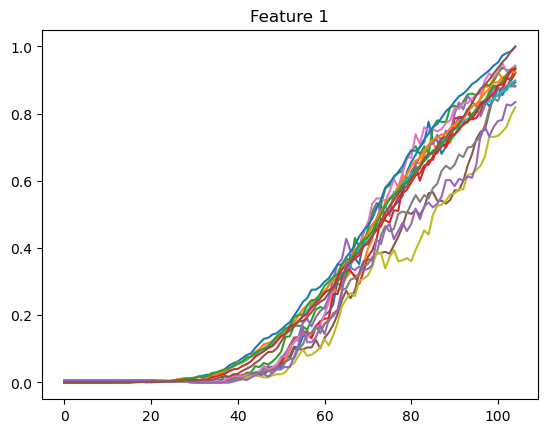

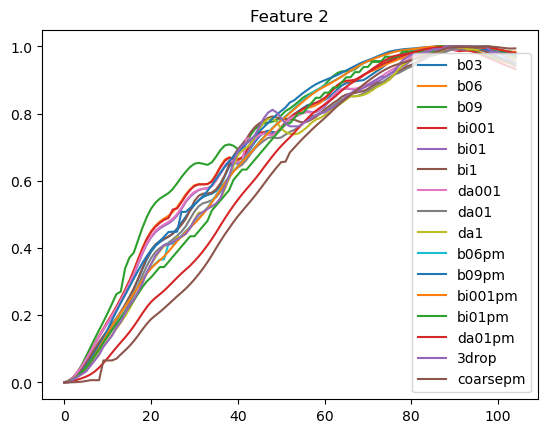

In [7]:
### looping over the number of features (Nd and IA)
for i in range(mydata.shape[-1]):
    plt.figure()
    plt.title(f'Feature {str(i+1)}')
    ### Feature 1 and 2 being Nd and IA, respectively
    for case, idx in zip(Allcases, range(len(Allcases))):
        plt.plot(mydata[:,idx,i], label = f'{str(case)}')

plt.legend()
plt.show()

### Smoothing the processed data

In [8]:
from scipy.signal import savgol_filter
from statsmodels.nonparametric.smoothers_lowess import lowess

def smoothing(data, method, window_size=None, poly_order=None, lowess_frac = None):
    '''
    Input array : 2D array per feature, with shape (times, cases)
    Three methods to smooth:
    
    'moveavg': requires window_size
    'savgol': requires window_size, poly_order
    'lowess': requires lowess_frac
    '''

    ## rolling window averaging method
    if method == 'moveavg':
        if window_size is None:
            raise ValueError('Window size required')
        smoothed_data = pd.DataFrame(data).rolling(window_size, axis = 0).mean()
        smoothed_data.fillna(pd.DataFrame(data),inplace=True)
    ## SavGol filter based on fitting least-squares polynomial to a window of data points
    elif method == 'savgol':
        if window_size is None or poly_order is None:
            raise ValueError('Mising input arguments: Windowsize/polyorder')
        smoothed_data = np.apply_along_axis(
                    lambda col: savgol_filter(col, window_size, poly_order),
                    axis = 0, arr=data)
    ## Locally Weighted Scatterplot Smoothing, locally fitting linear regressions
    elif method == 'lowess':
        if lowess_frac is None:
            raise ValueError('Lowess fraction required')
        smoothed_data = np.apply_along_axis(
                    lambda col: lowess(col,np.arange(len(col)),frac = lowess_frac,return_sorted=False),
                    axis = 0, arr = data)
    else:
        raise ValueError('Unsupported smoothing method')
    
    fig, ax = plt.subplots(1,2, figsize=(15,5))
    ax[0].plot(data)
    ax[0].set_title('Before')
    ax[1].plot(smoothed_data)
    ax[1].set_title('After')
    fig.suptitle(f'{method}', fontsize=18)
    plt.show()

    return smoothed_data

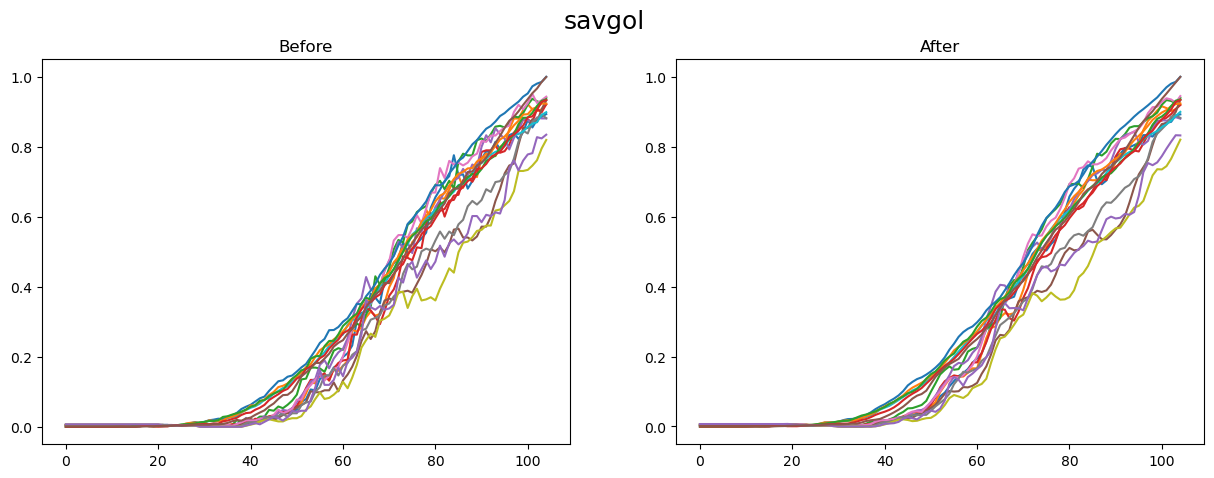

In [33]:
data = mydata[:,:,0] # 0 for drop number and 1 for IA
#smoothed_data = smoothing(data,'lowess',lowess_frac=0.06)
smoothed_data = smoothing(data,'savgol',window_size=5,poly_order=3)
#smoothed_data = smoothing(data,'moveavg',window_size=5)

## *Train, validation and test data set splitting*

In [41]:
## Split by times
def timeseries_split(df, train_frac, val_frac):
    '''
    input shape: (times, cases, features)
    
    return train, validation (and test) time steps
    '''
    train_size = int(len(df)*train_frac)
    val_size = train_size + int(len(df)*val_frac)
    
    # Setup for validation and test data sets
    if train_frac + val_frac < 1 :
        train, val, test = df[:train_size], df[train_size:val_size], df[val_size:] 
        print('train, val, test:',(train.shape, val.shape, test.shape))
        return train, val, test
    #Setup if split data will only be used for validation
    else:
        train, val = df[:train_size], df[train_size:]
        print('train, val:',(train.shape, val.shape))
        return train, val
    
### split by case
def cases_split(df, train_frac, cases):
    '''
    input shape: (times, cases, features)
    
    return train, val data and cases
    '''
    train_size = int(df.shape[1]*train_frac)
    
    train, val = df[:, :train_size, :], df[:, train_size:, :]
    print(f'train and val cases number: {train.shape[1]}, {val.shape[1]}')
    
    train_cases, val_cases = cases[:train_size], cases[train_size:]
    print(f'training cases: {train_cases}, validation cases: {val_cases}')
        
    return train, val, train_cases, val_cases

In [52]:
train_frac = 0.7
#val_frac = 0.2

mydata[:,:,0] = smoothed_data

f_data = mydata

train, val, train_cases, val_cases = cases_split(f_data, train_frac=train_frac, cases=Allcases)

print(f'train, val shapes: {train.shape}, {val.shape}')


train and val cases number: 11, 5
training cases: ['b03', 'b06', 'b09', 'bi001', 'bi01', 'bi1', 'da001', 'da01', 'da1', 'b06pm', 'b09pm'], validation cases: ['bi001pm', 'bi01pm', 'da01pm', '3drop', 'coarsepm']
train, val shapes: (105, 11, 2), (105, 5, 2)


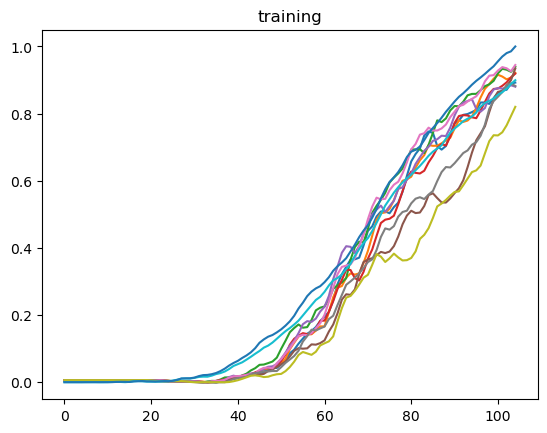

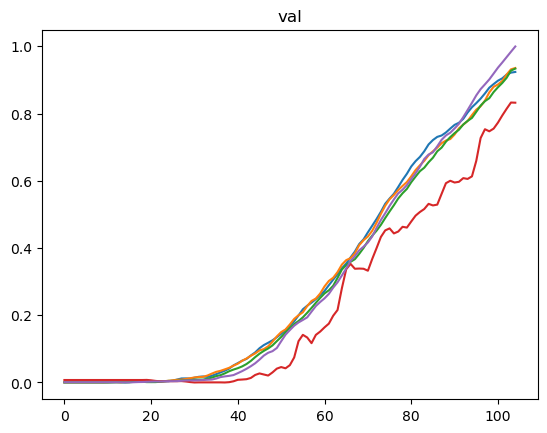

In [54]:
fig1 = plt.figure()
plt.plot(train[:,:,0])
plt.title('training')
fig1 = plt.figure()
plt.plot(val[:,:,0])
plt.title('val')
# plt.plot(test[:,0,:])
plt.show()

## *Train, validation and test data set splitting*

In [57]:
import torch

def window_data(df, steps_in, stride, steps_out):
    
    window_size = steps_in + steps_out
    
